# 0. Import libraries

The libraries used to create the data are in the following cell

In [1]:
# Project utils libraries

# From the constants library import the following constants
from constants import DATA_FOLDER_PATH

# From the plot surfaces library import the following functions
from plot_surfaces import plot_2d_polar_points, \
                          plot_2d_cartesian_points, \
                          plot_surface

# From the data generation library import the following functions
from data_generation import polar_samples_unit_circle_for_data_generation, \
                            cartesian_samples_unit_square_for_data_generation, \
                            get_random_zernike_coefficients, \
                            generate_data_for_convolutional_training, \
                            generate_data_for_linear_training
                            

# 1. Define paths

This section defines constants to be used in the notebook for saving the generated data

In [2]:
# Path constants
LINEAR_FEATURES_FILENAME = "linear_surfaces"
LINEAR_LABELS_FILENAME = "linear_coefficients"

CONV_FEATURES_FILENAME = "2d_surfaces"
CONV_LABELS_FILENAME = "2d_coefficients"

LINEAR_FEATURES_FILE_PATH = f"{DATA_FOLDER_PATH}/{LINEAR_FEATURES_FILENAME}"
LINEAR_LABELS_FILE_PATH = f"{DATA_FOLDER_PATH}/{LINEAR_LABELS_FILENAME}"

CONV_FEATURES_FILE_PATH = f"{DATA_FOLDER_PATH}/{CONV_FEATURES_FILENAME}"
CONV_LABELS_FILE_PATH = f"{DATA_FOLDER_PATH}/{CONV_LABELS_FILENAME}"

# 2. The process of generating data

We will be generating random surfaces using the **first 19 zernike polynomials** as our basis.

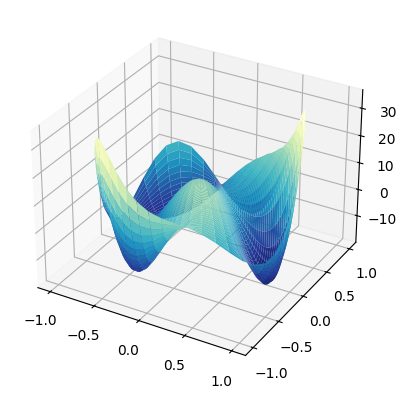

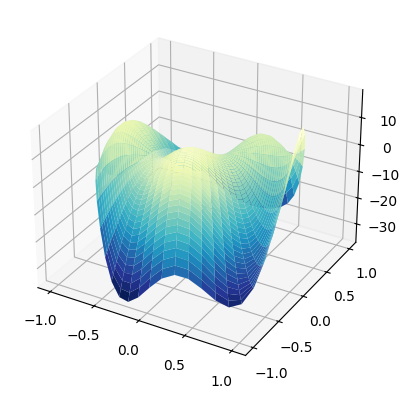

In [3]:
number_of_examples = 2
for i in range(0, number_of_examples):
    zernike_polynomials = get_random_zernike_coefficients()
    plot_surface(zernike_polynomials, verbose=True)

After creating the zernike polynomials that describe the surface we will make two types of sampling for the two different architectures for the neural network:
- **Linear NN**: We will sample 60 points inside the unit circle (the points will be described in polar coordinates) and its z values will be stored in a 1d array.


- **Convolutional NN**: We will sample 100 points inside the unit square (the points will be described in cartesian coordinates, this is because we will store the z values of the points in a matrix so that the convolutional nn can extract patterns)

#### Linear NN
Below it is shown the points in the rho-varphy (x-y) plane that will be evaluated

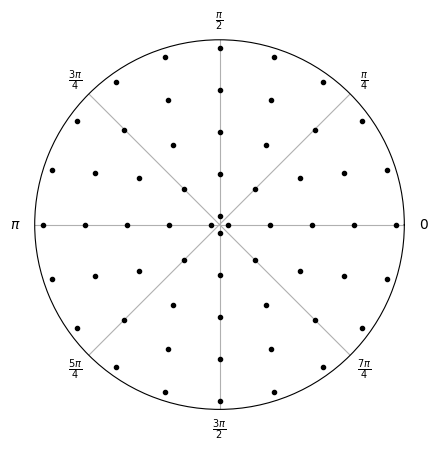

In [4]:
rho_array, varphi_array = polar_samples_unit_circle_for_data_generation()
plot_2d_polar_points(rho_array, varphi_array)

#### Convolutional NN
Below it is shown the points in the rho-varphy (x-y) plane that will be evaluated

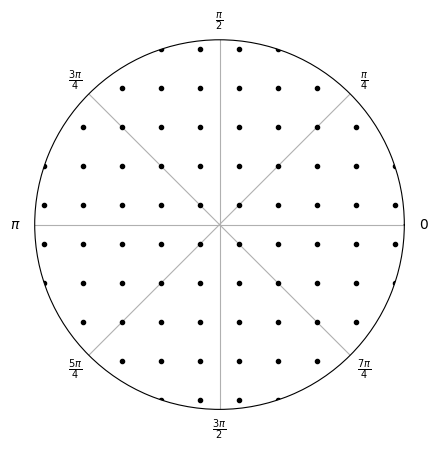

In [5]:
x_samples, y_samples = cartesian_samples_unit_square_for_data_generation()
plot_2d_cartesian_points(x_samples, y_samples)

We will repeat this process a number of times and store the z values of the surface and its zernike coefficients in a numpy array

# 3. Data generation

Firstly, we will create 60.000 data points for the linear architecture

In [12]:
n_surfaces = 60000

In [13]:
#generate_data_for_linear_training(n_surfaces,
#                                  LINEAR_FEATURES_FILE_PATH,
#                                  LINEAR_LABELS_FILE_PATH,
#                                  verbose=True)

Finally, we will create 60.000 data points for the convolutional architecture in the form of a matrix

In [14]:
generate_data_for_convolutional_training(n_surfaces,
                                         CONV_FEATURES_FILE_PATH,
                                         CONV_LABELS_FILE_PATH,
                                         verbose=True)